In [1]:
# Normal python mathy code
# Import Libraries:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle

## Modelo de movimento diferencial com dois motores e codificadores rotacionais

Para conduzir um robô de rastreio ('tracking robot') com dois motores (um motor à esquerda e outro à direita), controlamos a velocidade de cada roda para definir a trajetória do robô no plano $ (x, y) $. Neste tipo de robôs diferenciais, o movimento é determinado pela diferença de velocidade entre as rodas esquerda e direita.

### Modelação do Movimento do Robô no Plano $ (x, y) $

Suponhamos que:
- $ v_L $ é a velocidade linear da roda esquerda,
- $ v_R $ é a velocidade linear da roda direita,
- $ R $ é o raio da roda,
- $ d $ é a distância entre as rodas esquerda e direita (a base do robô).

### Velocidade Linear e Rotacional do Robô

A velocidade linear $v$ do robô (no centro do eixo entre as rodas) e a velocidade angular $ \omega $ (rotações por segundo) em torno do centro do robô são dadas por:

$$
v = \frac{v_L + v_R}{2}
$$

$$
\omega = \frac{v_R - v_L}{d}
$$

### Equações de Movimento no Plano

Se o robô começa num ponto inicial $ (x_0, y_0) $ com uma orientação inicial $ \theta_0 $ (ângulo em relação ao eixo $ x $), a posição do robô no tempo $ t $ pode ser calculada integrando a velocidade e a rotação ao longo do tempo. As equações de movimento são:

$$
x(t) = x_0 + \int_0^t v \cos(\theta(\tau)) \, d\tau
$$

$$
y(t) = y_0 + \int_0^t v \sin(\theta(\tau)) \, d\tau
$$

$$
\theta(t) = \theta_0 + \int_0^t \omega \, d\tau
$$

### Implementação Discreta

Para uma implementação discreta (em intervalos de tempo $ \Delta t $), podemos aproximar estas integrais para atualizar o estado do robô em cada instante $ k $:

$$
x_{k+1} = x_k + v \cos(\theta_k) \Delta t
$$

$$
y_{k+1} = y_k + v \sin(\theta_k) \Delta t
$$

$$
\theta_{k+1} = \theta_k + \omega \Delta t
$$

### Incorporar codificadores

Para incorporar as medições de velocidade usando os codificadores da roda esquerda e direita, precisamos entender que a velocidade de cada roda é determinada a partir das contagens dos codificadores em intervalos de tempo específicos. Cada codificador mede o número de "pulsos" ou "contagens" que ocorrem enquanto a roda gira, o que nos permite calcular a distância percorrida por cada roda e, portanto, a velocidade.

Vamos supor:
- $N_L$ e $N_R$ são as contagens de pulsos dos codificadores da roda esquerda e da roda direita, respetivamente, durante o intervalo de tempo $ \Delta t $.
- $P$ é o número de impulsos por rotação completo da roda (resolução do codificador).
- $R$ é o raio de cada roda.

Para o robot Zumo, o valor de $P$, o número de impulsos por rotação completo da roda (resolução do codificador), pode ser obtido da documentação online em: https://www.pololu.com/docs/0J63/3.4 $P = 900 CPR = 75 \cdot 12 CPR $ em que $CPR$ são as contagens por revolução do eixo, $75$ é o fator de redução da engrenagem mecânica entre o eixo da roda e o eixo do motor elétrico, e $12$ CPR as contagens de impulsos por rotação do eixo do motor. 

O raio da roda $R$ pode ser medido ou estimado da informação disponivel, é é o raio de cada roda.

Em alternativa, podem determinar em laboratório qual o incremento dos contadores para cada centímetro de movimento.

Seja qual o método de definir estes parâmetros, eles nunca serão 'perfeitos', ou seja, estarão associados a uma inverteza ou um 'erro' que deve ser mantida tão pequeno quanto possível, no entanto, nunca poderá ser eliminado. Como se vai ver adiante, esta incerteza introduz incerteza no control do movimento e estimação de velocidade e posição.

A distância percorrida por cada roda durante $ \Delta t $ pode ser obtida a partir da contagem de pulsos e da circunferência da roda ($ 2 \pi R $). Se $ N_L $ e $ N_R $ são as contagens de pulsos para a roda esquerda e direita, respetivamente, e $ \Delta N_L $ e $\Delta  N_R $ a variação das contagens desde a última medida, então a distância percorrida por cada roda ($ d_L $ para a roda esquerda e $ d_R $ para a direita) no intervalo de temp $dt$ é:

$$
\Delta d_L = \frac{\Delta N_L}{P} \cdot 2 \pi R
$$

$$
\Delta d_R = \frac{\Delta N_R}{P} \cdot 2 \pi R
$$

As velocidades lineares de cada roda, $ v_L $ e $ v_R $, são então dadas por:

$$
v_L = \frac{\Delta d_L}{\Delta t} = \frac{\Delta N_L}{P} \cdot \frac{2 \pi R}{\Delta t}
$$

$$
v_R = \frac{\Delta d_R}{\Delta t} = \frac{\Delta N_R}{P} \cdot \frac{2 \pi R}{\Delta t}
$$


### Planeamento do Movimento no Plano

Para conduzir o robô do ponto inicial ao ponto final, respeitando a orientação inicial e a orientação final desejada, podemos dividir o movimento em três etapas:

1. **Rotação Inicial**: Alinhar o robô na direção do ponto final.
2. **Translação**: Mover em linha reta até o ponto final.
3. **Rotação Final**: Ajustar a orientação para a orientação final desejada.

Suponhamos que:
- $ (x_0, y_0) $ e $ \theta_0 $ representam a posição e orientação iniciais do robô.
- $ (x_f, y_f) $ e $ \theta_f $ representam a posição e orientação finais desejadas do robô.
- A distância entre as rodas do robô é $ d $, e o controle é feito ajustando as velocidades angulares das rodas esquerda e direita.

#### Rotação Inicial

Primeiro, precisamos alinhar o robô na direção do ponto final $ (x_f, y_f) $.

1. **Cálculo do Ângulo de Direção**: Calcule o ângulo de orientação desejada, $ \theta_d $, entre o ponto inicial $ (x_0, y_0) $ e o ponto final $ (x_f, y_f) $:

   $$
   \theta_d = \arctan\left(\frac{y_f - y_0}{x_f - x_0}\right)
   $$

2. **Rotação até $ \theta_d $**: Ajuste a velocidade angular $ \omega $ do robô para alinhar a orientação atual $ \theta_0 $ com $ \theta_d $. A rotação pode ser feita definindo as velocidades das rodas esquerda e direita, $ v_L $ e $ v_R $, com sinais opostos:

   - Se $ \theta_0 < \theta_d $, rode o robô no sentido anti-horário.
   - Se $ \theta_0 > \theta_d $, rode o robô no sentido horário.

   A rotação é realizada com:
   
   $$
   v_L = -v \quad \text{e} \quad v_R = v
   $$

   onde $ v $ é a velocidade desejada, de modo a gerar uma velocidade angular constante $ \omega = \frac{2v}{d} $ até que o robô atinja $ \theta_d $.

#### Translação em Linha Reta até o Ponto Final

Uma vez alinhado na direção do ponto final, o robô pode mover-se em linha reta até o ponto $ (x_f, y_f) $.

1. **Distância até o Ponto Final**: Calcule a distância $ d_f $ entre a posição atual $ (x, y) $ e o ponto final $ (x_f, y_f) $:

   $$
   d_f = \sqrt{(x_f - x)^2 + (y_f - y)^2}
   $$

2. **Movimento em Linha Reta**: Mova o robô para frente com uma velocidade linear constante $ v $ até percorrer a distância $ d_f $. Durante este movimento, a velocidade angular deve ser zero para manter o robô na linha reta:

   $$
   v_L = v \quad \text{e} \quad v_R = v
   $$

   Continue o movimento até que a posição atual do robô atinja o ponto $ (x_f, y_f) $.

#### Rotação Final

Finalmente, o robô deve ajustar a sua orientação para o ângulo final desejado $ \theta_f $.

1. **Diferença de Orientação**: Calcule a diferença angular $ \Delta \theta $ entre a orientação atual $ \theta $ e a orientação final $ \theta_f $:

   $$
   \Delta \theta = \theta_f - \theta
   $$

2. **Rotação para $ \theta_f $**: Ajuste novamente as velocidades das rodas com sinais opostos para criar uma rotação até que a orientação atual coincida com $ \theta_f $.

   - Se $ \theta < \theta_f $, rode o robô no sentido anti-horário.
   - Se $ \theta > \theta_f $, rode o robô no sentido horário.

   A rotação final é realizada com:

   $$
   v_L = -v \quad \text{e} \quad v_R = v
   $$

   até que o ângulo do robô seja igual a $ \theta_f $.


# Conduzir um segmento linear

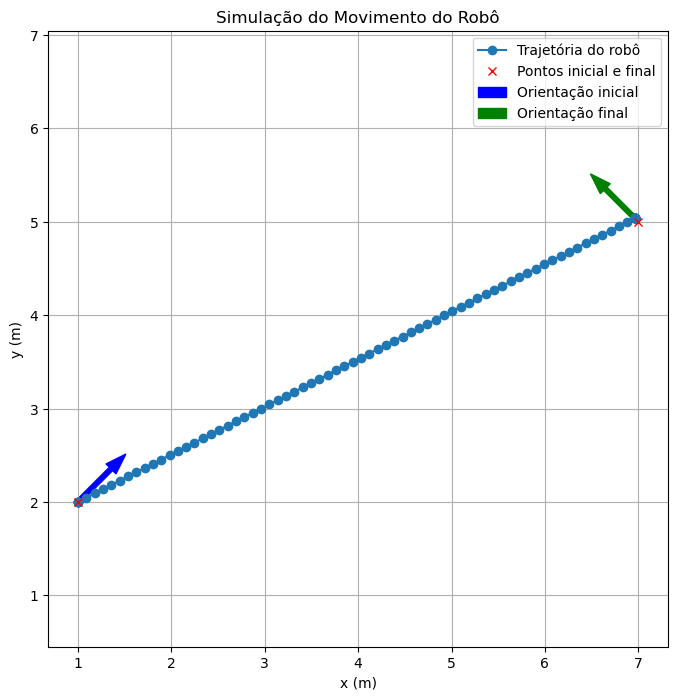

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do robô
v_linear = 1.0        # Velocidade linear (m/s)
v_angular = np.pi/4   # Velocidade angular (rad/s)

dt = 0.1              # Intervalo de tempo (s)

# Coordenadas e orientações iniciais e finais
x0, y0, theta0 = 1, 2, np.pi/4           # Ponto inicial e orientação inicial
xf, yf, thetaf = 7, 5, 3*np.pi/4         # Ponto final e orientação final

# Inicialização das variáveis
x, y, theta = x0, y0, theta0
trajectory_x = [x]
trajectory_y = [y]

# 1. Rotação inicial para alinhar o robô na direção do ponto final
theta_d = np.arctan2(yf - y0, xf - x0)
while abs(theta - theta_d) > 0.01:  # Até atingir a orientação desejada
    if theta < theta_d:
        theta += v_angular * dt
    else:
        theta -= v_angular * dt
    trajectory_x.append(x)
    trajectory_y.append(y)

# 2. Translação em linha reta até o ponto final
distance = np.sqrt((xf - x)**2 + (yf - y)**2)
while distance > 0.1:  # Até atingir o ponto final
    x += v_linear * np.cos(theta) * dt
    y += v_linear * np.sin(theta) * dt
    distance = np.sqrt((xf - x)**2 + (yf - y)**2)
    trajectory_x.append(x)
    trajectory_y.append(y)

# 3. Rotação final para atingir a orientação final desejada
while abs(theta - thetaf) > 0.01:  # Até atingir a orientação final
    if theta < thetaf:
        theta += v_angular * dt
    else:
        theta -= v_angular * dt
    trajectory_x.append(x)
    trajectory_y.append(y)

# Plot da trajetória
plt.figure(figsize=(8, 8))
plt.plot(trajectory_x, trajectory_y, '-o', label="Trajetória do robô")
plt.plot([x0, xf], [y0, yf], 'rx', label="Pontos inicial e final")
plt.arrow(x0, y0, 0.5 * np.cos(theta0), 0.5 * np.sin(theta0), color="blue", width=0.05, label="Orientação inicial")
plt.arrow(xf, yf, 0.5 * np.cos(thetaf), 0.5 * np.sin(thetaf), color="green", width=0.05, label="Orientação final")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.title("Simulação do Movimento do Robô")
plt.axis("equal")
plt.grid(True)
plt.show()


# Conduzir uma trajetória fechada

In [89]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation

In [221]:
# Parâmetros do robô
d=10 #cm, distancia entre rodas

# controlo de velocidade (da calibração)
pwm_max=400 #unidade?
vmax=10 #cm/s, with pwm_max applied to left and right motor
wmax=2*vmax/d # rad/s, with pwm_max applied to right motor and -pwm_max to left motor 

pwm=100;#valor usado para pwm 'speed'

vapp = vmax*pwm/pwm_max   # Velocidade linear aplicada (cm/s)
wapp = 2*vapp/d   # Velocidade angular aplicada (rad/s)

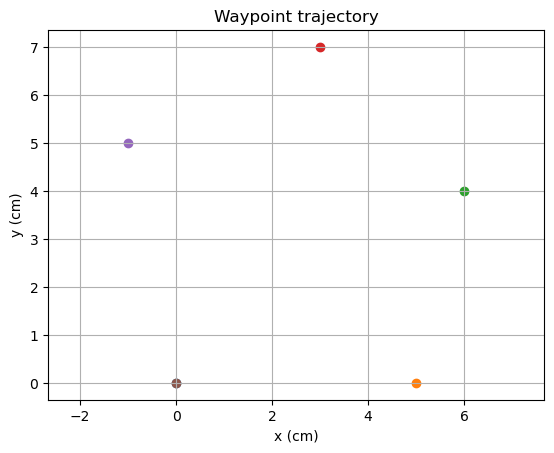

In [546]:
# coordenadas de vertices ('waypoints') de trajetoria alvo

wps = [
    (0, 0),
    (5, 0),
    (6, 4),
    (3, 7),
    (-1, 5),
]

# Fechar a trajetoria 
wps.append(wps[0])

for i in range(len(wps)):
    plt.scatter(wps[i][0], wps[i][1])
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.title("Waypoint trajectory")
plt.axis("equal")
plt.grid(True)
plt.show()

In [548]:
# Função para atualizar a posição e orientação do robô para cada segmento da trajetória
def move_robot(t_start, x_start, y_start, theta_start, x_end, y_end, theta_end):
       
    trajectory=[]
    
    global t,v,w,x,y,theta
    
    t=t_start 
    v=0
    w=0
    x=x_start
    y=y_start
    theta=theta_start

    # 1. Rotação inicial para alinhar com o ponto final
    w=wapp
    theta_d = np.arctan2(y_end - y_start, x_end - x_start)
    dtheta_before=abs(theta - theta_d)+1 #arbitrar valor anterior ao inicial

    #print('first')
    while abs(theta - theta_d) > 0.01 and abs(theta - theta_d) < dtheta_before:  # Até atingir a orientação desejada
        dtheta_before=abs(theta - theta_d)
        t+=dt
        if theta < theta_d:
            w=wapp
        else:
            w=-1*wapp
        theta += w * dt
        trajectory.append((t,v,w,x,y,theta))

    # 2. Translação em linha reta até o ponto final
    v=vapp
    w=0
    distance = np.sqrt((x_end - x)**2 + (y_end - y)**2)
    distance_before=distance+1  #arbitrar valor anterior
    #print('second')
    while distance > 0.1 and distance<distance_before:  # Até atingir o ponto final
        #print(distance)
        distance_before=distance
        t=t+dt
        x += v * np.cos(theta_d) * dt
        y += v * np.sin(theta_d) * dt
        trajectory.append((t,v,w,x,y,theta))
        distance = np.sqrt((x_end - x)**2 + (y_end - y)**2)

    '''
    # 3. Rotação final para atingir a orientação final desejada
    v=0
    w=wapp
    dtheta_before=abs(theta - theta_end)+1   #arbitrar valor anterior
    #print('third')
    while abs(theta - theta_end) > 0.01 and abs(theta - theta_end) < dtheta_before:  # Até atingir a orientação final
        #print(abs(theta - theta_end))
        t=t+dt
        if theta < theta_end:
            w=wapp
        else:
            w=-wapp
        theta += w * dt
        trajectory.append((t,v,w,x,y,theta))
        dtheta_before=abs(theta - theta_end)
        '''

    return trajectory

In [550]:
#start configuration

t0=0  #start time
dt = 0.05             # Intervalo de tempo (s)

# Inicialização da posição e orientação do robô
x0 = wps[0][0] 
y0 = wps[0][1]
theta0 = 0 

# Geração da trajetória completa para todos os segmentos 
full_trajectory= []
full_trajectory.append((t0,0,0,x0,y0,theta0))

#create movement along trajectory 
for i in range(len(wps)-1):
    t_start=full_trajectory[-1][0]
    x_start=wps[i][0]
    y_start=wps[i][1]
    x_end=wps[i+1][0]
    y_end=wps[i+1][1]
    if i==0: 
        theta_start = theta0 
    else:
        theta_start = theta_end_anterior
    theta_end = np.arctan2(y_end - y_start, x_end - x_start)
    segment_trajectory = move_robot(t_start, x_start, y_start, theta_start, x_end, y_end, theta_end)
    full_trajectory.extend(segment_trajectory)
    theta_end_anterior=theta_end

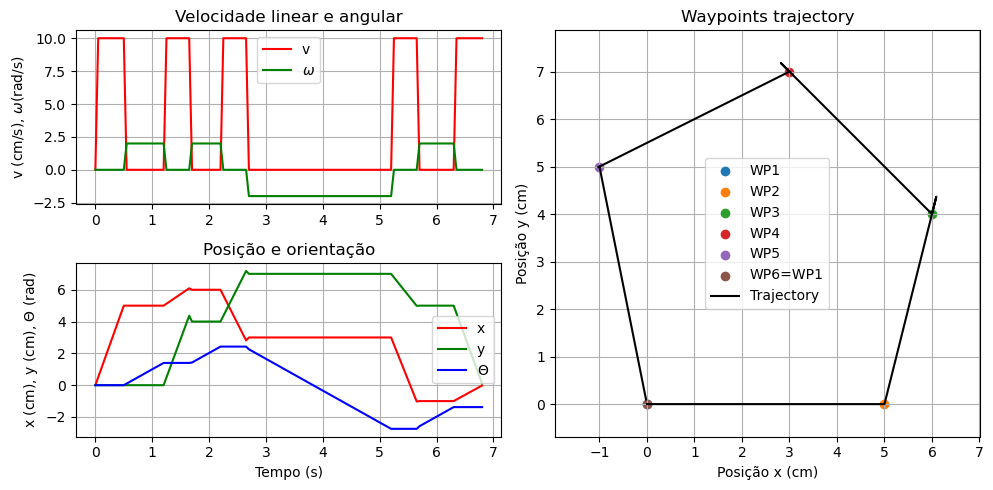

In [552]:
# Configuração da figura e dos subplots
fig = plt.figure(figsize=(10, 5))

t =  [x[0] for x in full_trajectory]  # Eixo do tempo 
v =  [x[1] for x in full_trajectory]  #velocidade linear
w =  [x[2] for x in full_trajectory]  #velocidade angular
x =  [x[3] for x in full_trajectory]  #posicao x
y=  [x[4] for x in full_trajectory]  #posicao y
theta =  [x[5] for x in full_trajectory]  #orientacao teta

# Subplot 1: 
ax1 = fig.add_subplot(2, 2, 1)  # 2 linhas, 2 colunas, posição 1
ax1.plot(t, v, color='red')
ax1.plot(t, w, color='green')
ax1.set_title("Velocidade linear e angular")
ax1.set_ylabel(r'v (cm/s), $\omega$(rad/s)')
ax1.legend(['v',r'$\omega$'])
ax1.grid(True)

# Subplot 2: 
ax2 = fig.add_subplot(2, 2, 3, sharex=ax1)  # 2 linhas, 2 colunas, posição 3
ax2.plot(t, x, color='red')
ax2.plot(t, y, color='green')
ax2.plot(t, theta, color='blue')
ax2.set_title("Posição e orientação")
ax2.set_xlabel("Tempo (s)")
ax2.set_ylabel(r'x (cm), y (cm), $\Theta$ (rad)')
ax2.legend(['x','y',r'$\Theta$'])
ax2.grid(True)

# Subplot 3: 
ax3 = fig.add_subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for i in range(len(wps)):
    plt.scatter(wps[i][0], wps[i][1])
ax3.plot(x, y, color='black')
ax3.set_title("Waypoints trajectory")
ax3.set_xlabel("Posição x (cm)")
ax3.set_ylabel("Posição y (cm)")
ax3.legend(['WP1','WP2','WP3','WP4','WP5','WP6=WP1','Trajectory'])
plt.axis("equal")
ax3.grid(True)

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show();

# Controlo direto ('feedforward') - gerar valores PWM para Zumo

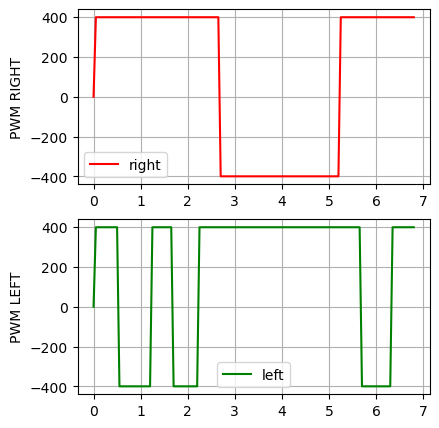

In [562]:
# Parâmetros do robô
d=10 #cm, distancia entre rodas

# controlo de velocidade
pwm_max=400 #unidade?
vmax=10 #cm/s, with pwm_max applied to left and right motor
wmax=2*vmax/d # rad/s, with pwm_max applied to right motor and -pwm_max to left motor 

pwm_right=[]
pwm_left=[]

for i in range(len(v)):
    pwm_right.append(pwm_max*(v[i]+w[i]*d/2)/vmax)
    pwm_left.append(pwm_max*(v[i]-w[i]*d/2)/vmax)
   
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t, pwm_right, color='red')
#ax1.set_title("PWM")
ax1.set_ylabel('PWM RIGHT')
ax1.legend(['right'])
ax1.grid(True)

# Subplot 2: 
ax2 = fig.add_subplot(2, 2, 3, sharex=ax1)
ax2.plot(t, pwm_left, color='green')
ax2.set_ylabel('PWM LEFT')
ax2.legend(['left'])
ax2.grid(True)

#Store values in correct format for arduino array